
## Поиск причины оттока водителей такси

Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются.  
Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку".  
На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

Вопросы для проверки:
1. Проверьте, есть ли различия в размерах оттока клиентов в разных городах
2. Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов?
3. Может ли отток быть связан с активностью в первые 30 дней после регистрации?

Перед проведением тестов проверьте распределения переменных, а также удовлетворяются ли параметрические условия.  
В зависимости от этого выберите правильный метод

прочитаем данные и проверим описательные статистики

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin
import pingouin as pg
from scipy.stats import chi2_contingency, chi2 
#from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
#import statsmodels.api as sa 
import scikit_posthocs as sp

import seaborn as sns
sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [25]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/406362/churn.csv', \
                 parse_dates=['last_trip_date', 'signup_date'])
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `city` – город
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `surge_pct` – процент поездок, совершенных с множителем > 1 
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [27]:
df[df.columns].nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [28]:
df.describe(include='object')

,city,phone
count,50000,49604
unique,3,2
top,Winterfell,iPhone
freq,23336,34582


In [29]:
df.describe(datetime_is_numeric=True)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000,50000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,2014-04-19 08:02:04.992000256,2014-01-16 13:04:20.352000,8.849536,2.278200,60.926084
min,0.000000,1.000000,1.000000,1.000000,2014-01-01 00:00:00,2014-01-01 00:00:00,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,2014-02-14 00:00:00,2014-01-09 00:00:00,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,2014-05-08 00:00:00,2014-01-17 00:00:00,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,2014-06-18 00:00:00,2014-01-24 00:00:00,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,2014-07-01 00:00:00,2014-01-31 00:00:00,100.000000,125.000000,100.000000
std,5.707357,0.446652,0.617338,0.222336,NaN,NaN,19.958811,3.792684,37.081503


## 2
Проверьте, есть ли различия в размерах оттока клиентов в разных городах (churn, city)

создаём столбец с разницей количества дней даты поездки и последнего дня в данных

In [30]:
df['days_since_last_trip'] = (df.last_trip_date.max() - df.last_trip_date).dt.days
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

Посмотрим на распределение количества дней с последней поездки

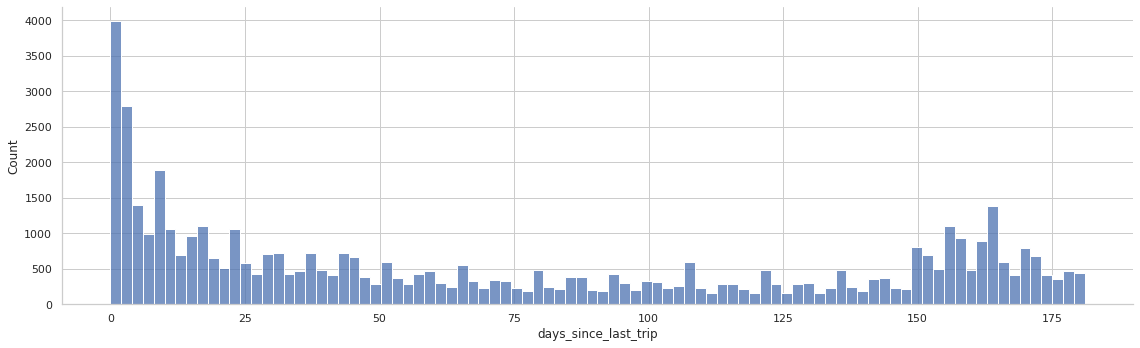

In [31]:
sns.displot(data=df, x='days_since_last_trip', aspect=16/5, bins=90)
sns.despine()

Определим временной лаг в 30 дней в качестве значения оттока.
Создадим колонку с категориальным значением 'churn'/'not_churn' определяющим поездку, совершенную раньше допустимого значения

Примечание:  
Предполагается более корректным определением временного лага вероятности оттока водителя - получение разницы в днях между последней и предпоследней поездкой у водителей которые покидали платформу ранее.  
Или определение макимального времени перерывов в днях 95% постоянно работающих водителей.  
Это возможно было-бы провернуть при наличии данных id водителей и его последних двух поездках

In [33]:
lag = 30 # дней, считается невозвратом
df['churn'] = df['days_since_last_trip'].apply(lambda x: 'churn' if x > lag else 'not_churn')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,days_since_last_trip,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,14,not_churn
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,57,churn
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,175,churn
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2,not_churn
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,108,churn


Посмотрим на различия групп 'churn'/'not_churn' относительно колонки city

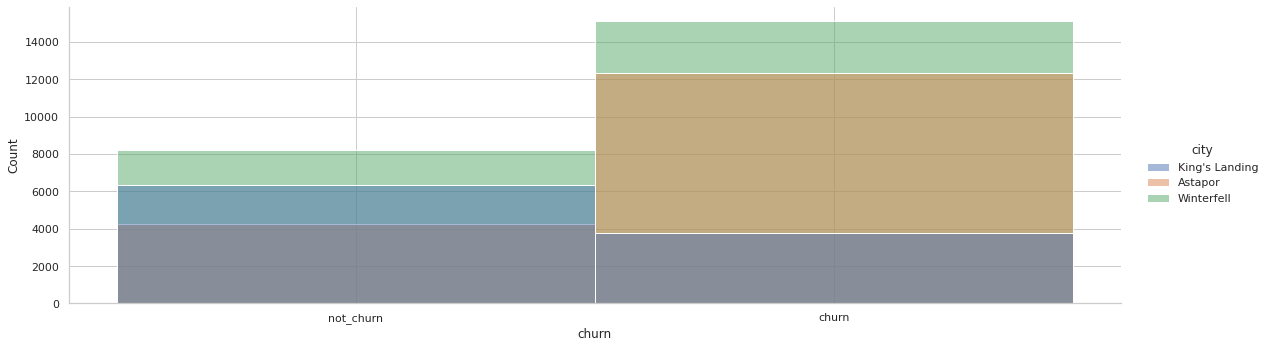

In [34]:
sns.displot(data=df, x='churn', hue='city', aspect=16/5)
sns.despine()

Наблюдается некоторая диспропорция

In [35]:
churn_city = pd.crosstab(df.churn, df.city).T
churn_city

churn,churn,not_churn
city,,
Astapor,12306,4228
King's Landing,3767,6363
Winterfell,15123,8213


Так как переменный категориальные, для сравнения будем применять хи-квадрат:

In [36]:
obs = np.array([churn_city.churn, churn_city.not_churn])
result = stats.chi2_contingency(obs)
print('statistics', result[0],
      '\npvalue', result[1],
      '\n', result[3])

statistics 3821.5510225559633 
pvalue 0.0 
 [[10315.89328  6320.3096  14559.79712]
 [ 6218.10672  3809.6904   8776.20288]]


pvalue<0.05 отклоняем H0 стат значимые различия  между группами  'churn'/'not_churn' есть

Из этого следует что отток зависит от города:  
работорговцы (Astapor), и Старки (Winterfell) - показывают сравнительно сильный отток  
Столица семи королевств (King's Landing) показывает лучшие результаты.  

In [48]:
# через pingouin
pg.chi2_independence(df, x='churn', y='city')

(city           Astapor  King's Landing   Winterfell
 churn                                              
 churn      10315.89328       6320.3096  14559.79712
 not_churn   6218.10672       3809.6904   8776.20288,
 city       Astapor  King's Landing  Winterfell
 churn                                         
 churn        12306            3767       15123
 not_churn     4228            6363        8213,
                  test    lambda         chi2  dof  pval    cramer  power
 0             pearson  1.000000  3821.551023  2.0   0.0  0.276462    1.0
 1        cressie-read  0.666667  3788.042430  2.0   0.0  0.275247    1.0
 2      log-likelihood  0.000000  3767.315031  2.0   0.0  0.274493    1.0
 3       freeman-tukey -0.500000  3791.421829  2.0   0.0  0.275370    1.0
 4  mod-log-likelihood -1.000000  3849.643594  2.0   0.0  0.277476    1.0
 5              neyman -2.000000  4073.406300  2.0   0.0  0.285426    1.0)

## 3
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов?  
(city, trips_in_first_30_days)

Проверим распределения на нормальность

In [37]:
pingouin.normality(data=df, dv='trips_in_first_30_days', group='city', method='normaltest')

,W,pval,normal
King's Landing,12011.013892,0.0,False
Astapor,18186.739338,0.0,False
Winterfell,21390.545655,0.0,False


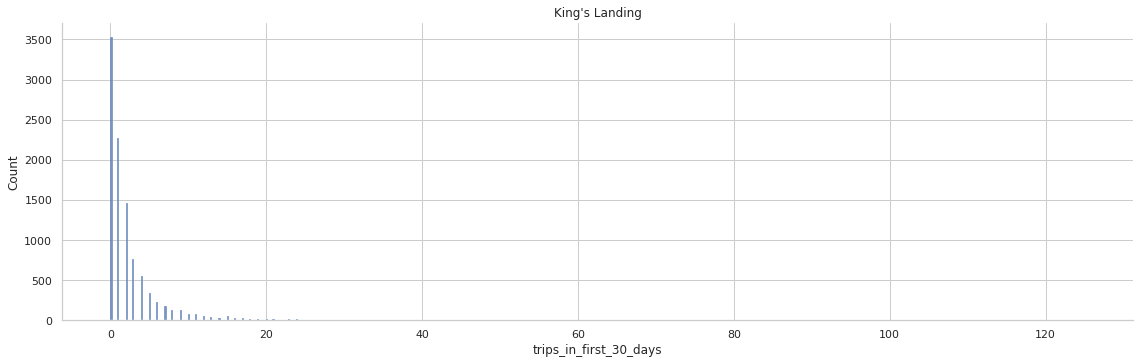

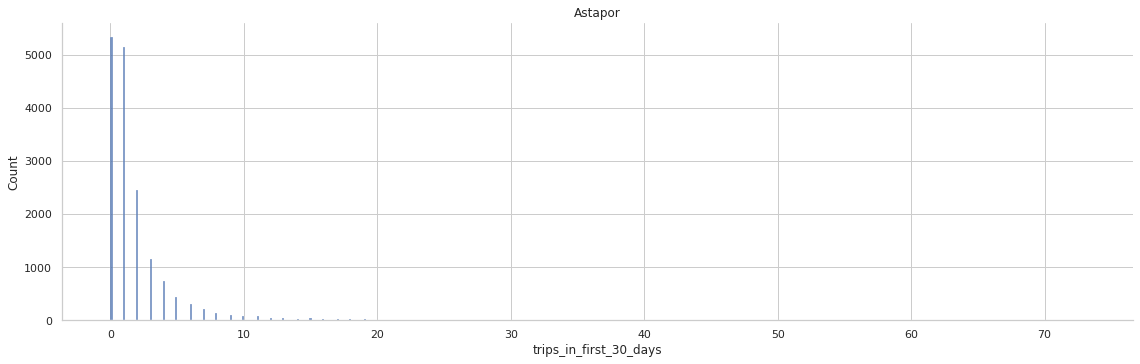

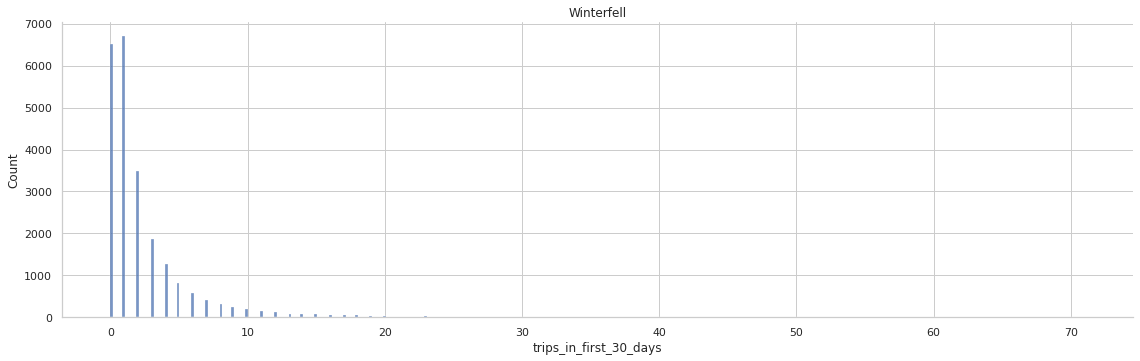

In [38]:
for city in df.city.unique():
    sns.displot(df[df.city == city].trips_in_first_30_days, aspect=16/5).set(title=city)

pvalue<0.05 у всех трех городов, графики не имеет форму нормального распределения, также имеются значительные выбросы.  

Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса

## 4
Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов?  
(city, trips_in_first_30_days)

Обнаружены ли статистически значимые различия?

In [39]:
x, y, z = [df[df.city == x].trips_in_first_30_days for x in df.city.unique()]
stats.kruskal(x, y, z)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

In [49]:
pg.kruskal(df, dv='trips_in_first_30_days', between='city')

,Source,ddof1,H,p-unc
Kruskal,city,2,221.321053,8.724568e-49


pvalue<0.05 обнаружены статистически значимые различия

In [52]:
# непараметрический games howell
pg.pairwise_gameshowell(data=df, dv='trips_in_first_30_days', between='city')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Astapor,King's Landing,1.948651,2.463672,-0.515021,0.050196,-10.260168,17426.337201,0.001000,-0.129453
1,Astapor,Winterfell,1.948651,2.431179,-0.482528,0.036089,-13.370534,38248.767769,0.001000,-0.135913
2,King's Landing,Winterfell,2.463672,2.431179,0.032493,0.049778,0.652762,17342.748103,0.770114,0.007767


In [54]:
sp.posthoc_dunn(a=df, val_col='trips_in_first_30_days', group_col='city', p_adjust='holm')

,Astapor,King's Landing,Winterfell
Astapor,1.000000e+00,1.313616e-09,2.448501e-49
King's Landing,1.313616e-09,1.000000e+00,8.440212e-10
Winterfell,2.448501e-49,8.440212e-10,1.000000e+00


Holm показал что активность водителей в первые 30 дней статистически различаются между собой данные во всех городах

## 5
Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [40]:
pingouin.normality(data=df, dv='trips_in_first_30_days', group='churn', method='normaltest')

,W,pval,normal
not_churn,16960.202341,0.0,False
churn,36325.245749,0.0,False


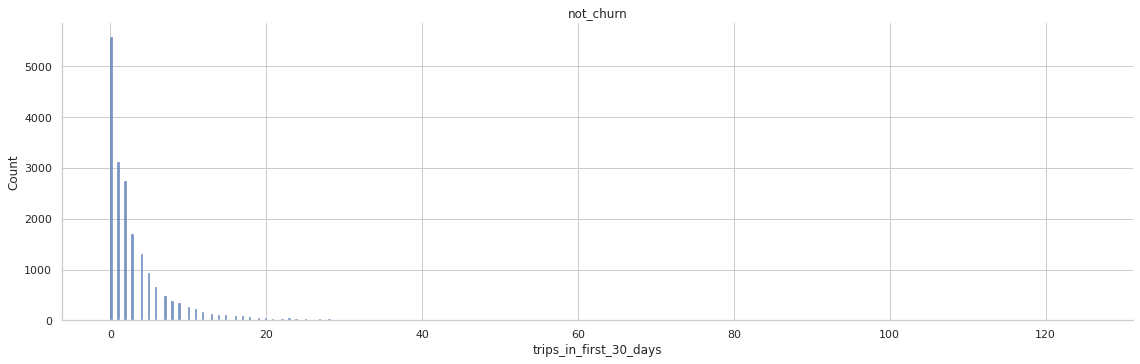

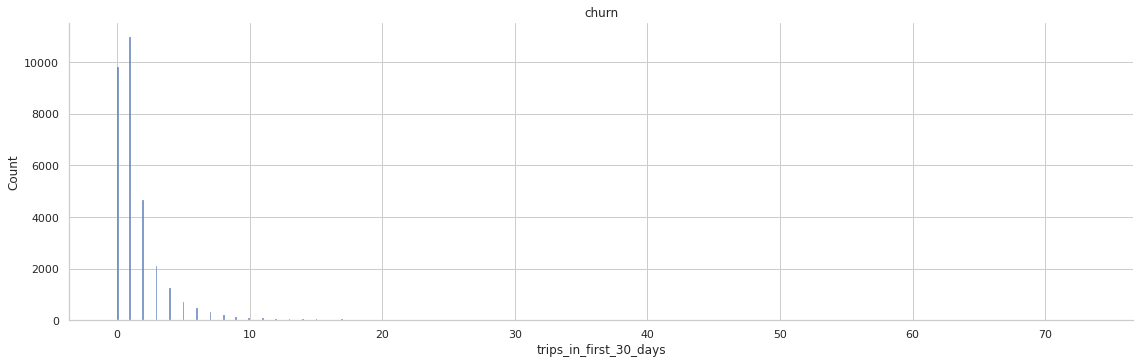

In [41]:
for c in df.churn.unique():
    sns.displot(df[df.churn == c].trips_in_first_30_days, aspect=16/5).set(title=c)

In [42]:
churn_30 = pd.crosstab(df.churn, df.trips_in_first_30_days).T
churn_30.head()

churn,churn,not_churn
trips_in_first_30_days,,
0,9810,5580
1,10983,3125
2,4659,2743
3,2095,1693
4,1249,1313


###  хи-квадрат
мы не будем применять поскольку у нас не таблица сопряжённости, а нам нужно сравнить средние

### Mann-Whitney U test
Поскольку распределения у нас не нормальные, а сравниваем два значения

In [43]:
a, b = [df[df.churn == x].trips_in_first_30_days for x in df.churn.unique()]
stats.mannwhitneyu(a, b, alternative='two-sided')

MannwhitneyuResult(statistic=351842132.0, pvalue=0.0)

pvalue<0.05 обнаружены статистически значимые различия

In [44]:
churn_30.churn.mean()

528.7457627118644

In [45]:
churn_30.not_churn.mean()

318.7118644067797

In [55]:
df.groupby('churn').trips_in_first_30_days.describe()

,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
churn,31196.0,1.658482,2.654222,0.0,0.0,1.0,2.0,73.0
not_churn,18804.0,3.306318,4.986743,0.0,0.0,2.0,4.0,125.0


Распределение переменной trips_in_first_30_days не является нормальным, поэтому для проверки гипотезы я использую U-test Mann Whitney
Результат оказался статистически значимым.  
Значит, значимые различия есть, ушедшие пользователи были менее активны.